In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import copy

import torch
import torchvision
import timm
from PIL import Image
from torch.utils.data import DataLoader
from torchvision.models import vit_b_16, ViT_B_16_Weights
sys.path.append('../')


from models import load_pretrained
from loader import get_dataloader
from utils.utils import label_to_color, figure_to_array, PD_metric_to_ellipse

device = 'cuda:0'


In [2]:
from loader.CIFAR_dataset import CIFAR10_
from loader.MNIST_dataset import MNIST_
from torchvision import transforms
dcifar = CIFAR10_(
    root='../dataset',
    download=True,
    transform=transforms.Compose(
        [transforms.Resize(224),
        transforms.ToTensor()]
    )
)

dmnist =  MNIST_(
    root='../dataset',
    download=True,
    digits=[0,1,2,3,4,5,6,7,8,9],
    transform=transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.Resize(224),
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor()
        ]
    ) 
)

dlmnist = DataLoader(dmnist, batch_size=100, shuffle=False)
dlcifar = DataLoader(dcifar, batch_size=100, shuffle=False)

x, _ = next(iter(dlmnist))
x.size()

Files already downloaded and verified
Split training | (45000, 32, 32, 3)
MNIST split training | torch.Size([50000, 1, 28, 28])


torch.Size([100, 3, 224, 224])

In [3]:
# # Get MNIST Dataset dataloader
# irvae, cfg = load_pretrained(
#     identifier='MNIST/DIM_2/irvae_mnist_01_isoreg_100',
#     config_file='mnist_irvae_z2.yml',
#     ckpt_file='model_best.pkl',
#     root='../results'
# )

# val_data_cfg = cfg['data']['validation']

# val_data_cfg['root'] = '../dataset'
# val_data_cfg['digits'] = 'list_0123456789'
# print(val_data_cfg)
# dl = get_dataloader(val_data_cfg)

torch.Size([100, 3, 224, 224])


(-0.5, 2261.5, 2261.5, -0.5)

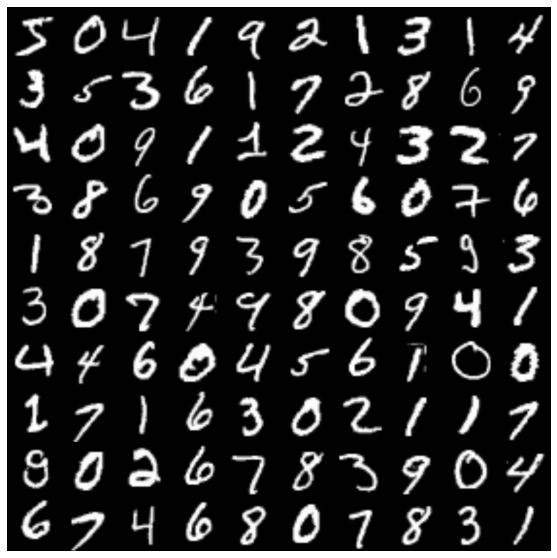

In [4]:
from torchvision.utils import make_grid
x, _ = next(iter(dlmnist))
x_img = make_grid(x.detach().cpu(), nrow=10, range=(0, 1))
print(x.shape)
plt.figure(figsize=(10, 10))
plt.imshow(x_img.permute(1, 2, 0))
plt.axis('off')

In [5]:
## Create Pretrained model of VIT

model = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
device = f'cuda:{0}'
model.to(device);

In [7]:
print(type(model))
print(callable(vit_b_16))

<class 'torchvision.models.vision_transformer.VisionTransformer'>
True


In [ ]:
## Create pretrained model of VIT trained oon ImageNet 21k 
# model = timm.create_model('vit_base_patch16_224_in21k', img_size=28, in_chans=1, pretrained=True, num_classes=0, global_pool='')

# model = timm.create_model(
#     'vit_base_patch16_224_in21k', 
#     img_size=32, 
#     in_chans=3, 
#     pretrained=True
# )

with torch.no_grad():
    list_image = []
    list_feature_vecs = []
    list_labels = []

    for i, (x, y) in enumerate(dlcifar):
        f = model(x.to(device))
        list_image.append(copy.copy(x.detach()))
        list_feature_vecs.append(copy.copy(f.detach()))
        list_labels.append(y)
        if i > 100:
            break
    image_vecs = torch.cat(list_image, dim=0)
    feature_vecs = torch.cat(list_feature_vecs, dim=0)
    label_vecs = torch.cat(list_labels)


In [ ]:
num_ex = 1
k = 10
rand_idxs = torch.randperm(len(feature_vecs))[:num_ex]

ex_image = image_vecs[rand_idxs]
ex_data = feature_vecs[rand_idxs]
ex_label = label_vecs[rand_idxs]

pairwise_dist_mat = torch.norm(ex_data.unsqueeze(1) - feature_vecs.unsqueeze(0), dim=-1)
k_closet_indices = torch.topk(pairwise_dist_mat, k=k+1, largest=False).indices[0, 1:].cpu()
ex_label, label_vecs[k_closet_indices]

print(ex_label)
print(label_vecs[k_closet_indices])

torch_img = torch.cat((ex_image, image_vecs[k_closet_indices]) ,  dim=0)

x_img = make_grid(torch_img.detach().cpu(), nrow=torch_img.shape[0], range=(0, 1))

plt.figure(figsize=(20, 20))
plt.imshow(x_img.permute(1, 2, 0))
plt.axis('off')


In [ ]:
## Create Pretrained model of VIT

model = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
device = f'cuda:{0}'
model.to(device);

In [ ]:

## Create pretrained model of VIT trained oon ImageNet 21k 
# model = timm.create_model('vit_base_patch16_224_in21k', img_size=28, in_chans=1, pretrained=True, num_classes=0, global_pool='')

# model = timm.create_model(
#     'vit_base_patch16_224_in21k', 
#     img_size=32, 
#     in_chans=3, 
#     pretrained=True
# )

with torch.no_grad():
    list_image = []
    list_feature_vecs = []
    list_labels = []

    for i, (x, y) in enumerate(dlmnist):
        f = model(x.to(device))
        list_image.append(copy.copy(x.detach()))
        list_feature_vecs.append(copy.copy(f.detach()))
        list_labels.append(y)
        if i > 100:
            break
    image_vecs = torch.cat(list_image, dim=0)
    feature_vecs = torch.cat(list_feature_vecs, dim=0)
    label_vecs = torch.cat(list_labels)


In [ ]:
k = 10

final_img_list = []

for i in range(10):
    idx = (label_vecs == i).nonzero(as_tuple=True)[0][0]
    
    ex_image = image_vecs[idx:idx+1]
    ex_data = feature_vecs[idx:idx+1]
    ex_label = label_vecs[idx:idx+1]

    pairwise_dist_mat = torch.norm(ex_data.unsqueeze(1) - feature_vecs.unsqueeze(0), dim=-1)
    k_closet_indices = torch.topk(pairwise_dist_mat, k=k+1, largest=False).indices[0, 1:].cpu()
    ex_label, label_vecs[k_closet_indices]

    final_img_list.append(ex_image)
    final_img_list.append(image_vecs[k_closet_indices])

torch_img = torch.cat(final_img_list, dim=0)
x_img = make_grid(torch_img.detach().cpu(), nrow=11, range=(0, 1))

plt.figure(figsize=(20, 20))
plt.imshow(x_img.permute(1, 2, 0))
plt.axis('off')

In [ ]:
# Amend VIT NN to get MNIST data as input

dlmnist_wo_trans =  MNIST_(
    root='../dataset',
    download=True,
    digits=[0,1,2,3,4,5,6,7,8,9]
)

dlmnist_wo_trans = DataLoader(dlmnist_wo_trans, batch_size=100, shuffle=False)

x, _ = next(iter(dlmnist_wo_trans))

print(x.shape)

In [ ]:
import torch.nn.functional as F

up_sampled = F.interpolate(x, size=(224, 224), mode='bilinear')
channel_expanded = up_sampled.repeat(1, 3, 1, 1)

In [ ]:
# Create new network having MNIST as input and VIT output as output

class enhanced_VIT(torch.nn.Module):
    def __init__(self):
        super(enhanced_VIT, self).__init__()
        self.vit = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)

    def forward(self, x):
        x = F.interpolate(x, size=(224, 224), mode='bilinear')
        x = x.repeat(1, 3, 1, 1)

        # print(f"vit input shape: {x.shape}")
        x = self.vit(x)

        return x

In [ ]:
# make model

model = enhanced_VIT()
model.to(device=device)

with torch.no_grad():
    list_image = []
    list_feature_vecs = []
    list_labels = []

    for i, (x, y) in enumerate(dlmnist_wo_trans):
        # print(x.shape)
        f = model(x.to(device))
        list_image.append(copy.copy(x.detach()))
        list_feature_vecs.append(copy.copy(f.detach()))
        list_labels.append(y)
        if i > 100:
            break
    image_vecs = torch.cat(list_image, dim=0)
    feature_vecs = torch.cat(list_feature_vecs, dim=0)
    label_vecs = torch.cat(list_labels)


In [ ]:
k = 10

final_img_list = []

for i in range(10):
    idx = (label_vecs == i).nonzero(as_tuple=True)[0][0]
    
    ex_image = image_vecs[idx:idx+1]
    ex_data = feature_vecs[idx:idx+1]
    ex_label = label_vecs[idx:idx+1]

    pairwise_dist_mat = torch.norm(ex_data.unsqueeze(1) - feature_vecs.unsqueeze(0), dim=-1)
    k_closet_indices = torch.topk(pairwise_dist_mat, k=k+1, largest=False).indices[0, 1:].cpu()
    ex_label, label_vecs[k_closet_indices]

    final_img_list.append(ex_image)
    final_img_list.append(image_vecs[k_closet_indices])

torch_img = torch.cat(final_img_list, dim=0)
x_img = make_grid(torch_img.detach().cpu(), nrow=11, range=(0, 1))

plt.figure(figsize=(20, 20))
plt.imshow(x_img.permute(1, 2, 0))
plt.axis('off')